In [ ]:
import os

drive_project_path = r"/content/drive/MyDrive/Colab Notebooks/Project2/Project2Group3"
os.chdir(drive_project_path)

!pip install -r requirements.txt


import json
import pandas as pd
import holoviews as hv
import hvplot.pandas

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from datetime import datetime
from alpaca_trade_api.rest import REST, TimeFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from data_preparation import retreve_data_from_alpaca as rdfa

# 0. Alpaca
#### Collecting data from alpaca API for BTCUSD and ETHUSD pairs and two time periods: 2018 - today (5 years) and 2022 - today (last year)

In [3]:
today = datetime.today().strftime('%Y-%m-%d')
dataBTCUSD2022today = rdfa("BTCUSD", TimeFrame.Hour, "2022-01-01", today)
dataETHUSD2022today = rdfa("ETHUSD", TimeFrame.Hour, "2022-01-01", today)

dataBTCUSD2022today.to_csv("./data/dataBTCUSD2022today.csv", index=None)
dataETHUSD2022today.to_csv("./data/dataETHUSD2022today.csv", index=None)

dataBTCUSD2018today = rdfa("BTCUSD", TimeFrame.Hour, "2018-01-01", today)
dataBTCUSD2018today.to_csv("./data/dataBTCUSD2018today.csv", index=None)

dataETHUSD2018today = rdfa("ETHUSD", TimeFrame.Hour, "2018-01-01", today)
dataETHUSD2018today.to_csv("./data/dataETHUSD2018today.csv", index=None)

# 1 Prophet
#### 1.1 Fitting Prophet models for  BTCUSD and ETHUSD  5 year interval.

In [6]:
dataBTCUSD2018today = pd.read_csv("./data/dataBTCUSD2018today.csv")
dataETHUSD2018today = pd.read_csv("./data/dataETHUSD2018today.csv")


# Create model object for BTCUSD
btcmodel = Prophet() # Create model object
btcmodel.fit(dataBTCUSD2018today) # fit model 

# Create model object for ETHUSD
ethmodel = Prophet() # Create model object
ethmodel.fit(dataETHUSD2018today) # fit model 

# Save fitted models as json files 
with open('./models/serialized_btcmodel2018.json', 'w') as fout:
    json.dump(model_to_json(btcmodel), fout)  # Save model for BTCUSD
with open('./models/serialized_ethmodel2018.json', 'w') as fout:
    json.dump(model_to_json(ethmodel), fout)  # Save model for ETHUSD

DEBUG:cmdstanpy:input tempfile: /tmp/tmpwe8_f7w7/yzn4opf7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwe8_f7w7/zdx42eo2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2949', 'data', 'file=/tmp/tmpwe8_f7w7/yzn4opf7.json', 'init=/tmp/tmpwe8_f7w7/zdx42eo2.json', 'output', 'file=/tmp/tmpwe8_f7w7/prophet_modelgevw6b8e/prophet_model-20221202052902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:29:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:30:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwe8_f7w7/gvhj9zk1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwe8_f7w7/b5sy7vco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

#### 1.2 Predicting 1 month ahead with Prophet for BTCUSD and ETHUSD

In [9]:
with open('./models/serialized_btcmodel2018.json', 'r') as fin:
    btcmodel = model_from_json(json.load(fin))  # Load model

with open('./models/serialized_ethmodel2018.json', 'r') as fin:
    ethmodel = model_from_json(json.load(fin))  # Load model

# Predicting future month for BTC
btc_future = btcmodel.make_future_dataframe(periods=720, freq='H')
btc_forecast = btcmodel.predict(btc_future)

# Predicting future month for ETH
eth_future = ethmodel.make_future_dataframe(periods=720, freq='H')
eth_forecast = ethmodel.predict(eth_future)

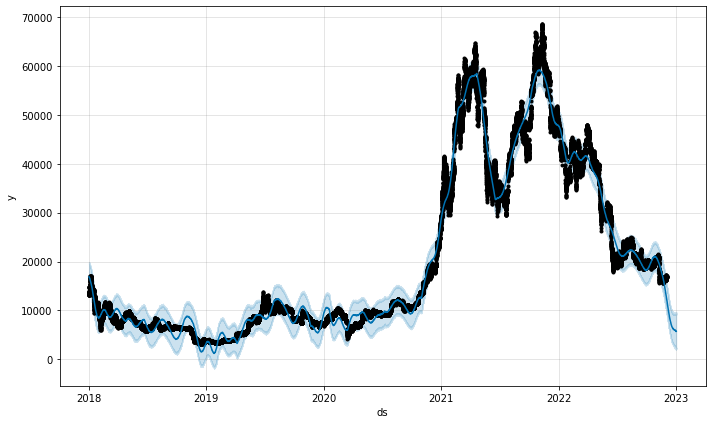

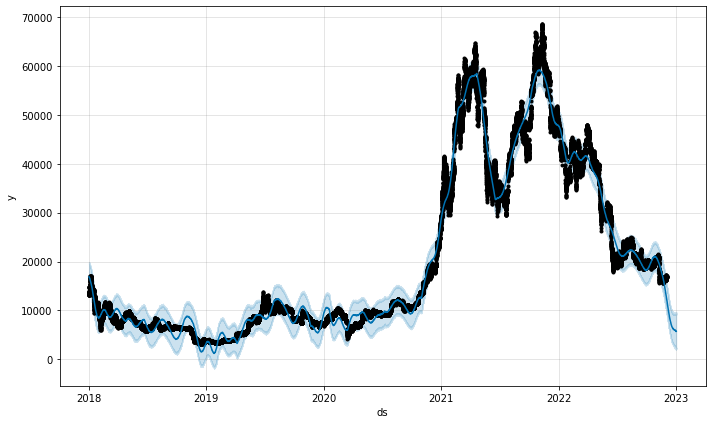

In [10]:
btcmodel.plot(btc_forecast)

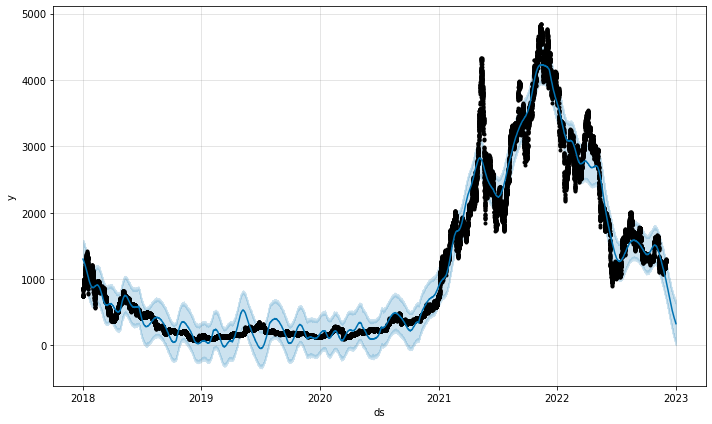

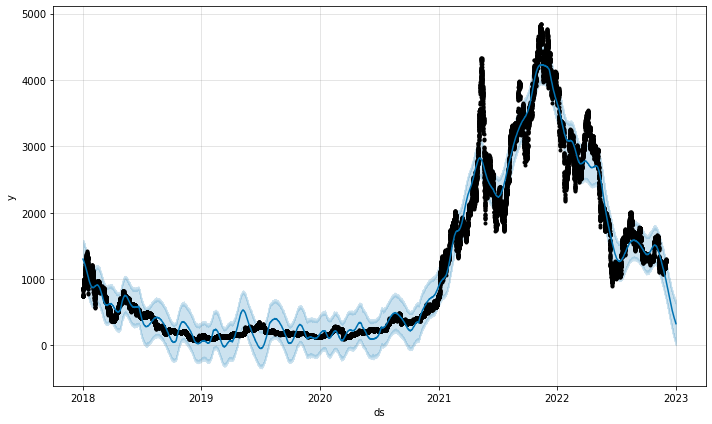

In [11]:
ethmodel.plot(eth_forecast)

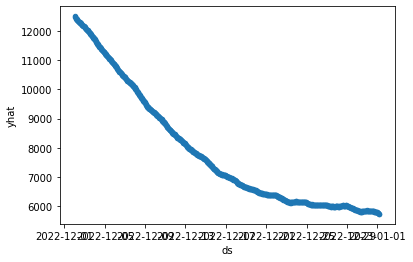

In [12]:
# Next month prediction for BTCUSD
btc_forecast[btc_forecast.ds > today].plot(x='ds', y='yhat', kind='scatter')

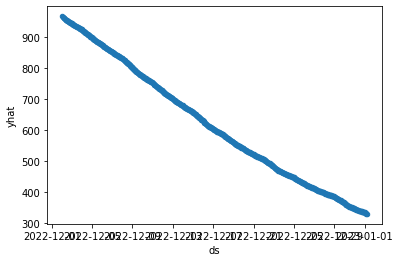

In [13]:
# Next month prediction for BTCUSD
eth_forecast[eth_forecast.ds > today].plot(x='ds', y='yhat', kind='scatter')

:# 1.3 Prophet result 
#### As a result we can see that the prediction depends on a period of time that we use for fitting Prophet model. So if we let the model see the period before 2020 it tends to be less optimistic about the future prices. 
#### I would recommend to take the average between two predictions.
#### So BTCUSD would reach as low as 9000 by the end of the year 2022.
#### And ETHUSD - 400 
#### So the recommendation is to sell both currencies.

# 2. Strategy Trading 
#### 2.1 Prepare 1 year BTCUSD data for feature engineering 

In [41]:
# Filter the date index and close columns
signals_df = pd.read_csv("./data/dataBTCUSD2022today.csv", index_col=False)
signals_df.columns = ['time', 'close']

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()
signals_df = signals_df.dropna()

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df['Signal'] = 0.0
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

#### 2.2 Feature engineering with different windows

In [42]:
for i in range(2, 50):
  signals_df[f'SMA_{i}'] = signals_df['close'].rolling(window=i).mean()
  signals_df[f'EMA_{i}'] = signals_df['close'].ewm(span=i).mean()

neaw_feature_names = [c for c in signals_df.columns if (c.startswith("SMA") or c.startswith("EMA"))]
signals_df = signals_df.dropna()

#### 2.3 Separate data for validation the trading algorithm

In [43]:
signals_df_validation = signals_df[signals_df.time > '2022-10-30']
signals_df_model2train = signals_df[signals_df.time < '2022-10-30']

# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df_model2train[neaw_feature_names].shift().dropna()
X_validation = signals_df_validation[neaw_feature_names].shift().dropna()

# Create the target set selecting the Signal column and assiging it to y
y = signals_df_model2train['Signal'].iloc[1:,]
y_validation = signals_df_validation['Signal'].iloc[1:,]

In [45]:
# Splitting data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Apply the scaler model to fit the X-train data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_validation_scaled = X_scaler.transform(X_validation)

#### 2.4 Training and evaluating LogisticRegression model 

In [52]:
# Initiate the model instance
model = LogisticRegression()

# Fit the model using the training data
model.fit(X_train, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))

              precision    recall  f1-score   support

        -1.0       0.53      0.54      0.54      1180
         1.0       0.54      0.53      0.53      1187

    accuracy                           0.54      2367
   macro avg       0.54      0.54      0.54      2367
weighted avg       0.54      0.54      0.54      2367



In [54]:
# Now lets use dimensionality reduction technique to select best features that were created in 2.2
# Hear we take coefficients of pretrained LogisticRegression model. They can be interpreted as values of feature.
# Ordering the values allows us to retreave most valuable features for using them in a model.
d = {k:v for k, v in zip(list(X.columns.values), model.coef_[0])}
ordered_coefs_df =  pd.DataFrame.from_dict({k: v for k, v in sorted(d.items(), key=lambda item: abs(item[1]), ) },  orient='index')
ordered_coefs_df

,0
EMA_7,9.356797e-09
EMA_42,-3.287196e-06
EMA_41,5.825027e-06
EMA_8,7.702718e-06
EMA_9,1.092998e-05
...,...
EMA_3,-3.079926e-04
SMA_21,3.093142e-04
SMA_5,3.715432e-04
SMA_4,4.752861e-04


#### 2.5 Evaluating strategy 

In [93]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_validation.index)
predictions_df['Predicted'] = model.predict(X_validation_scaled)
predictions_df['Actual Returns'] = signals_df_validation['Actual Returns']
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df.index = signals_df_validation.time[X_validation.index.values]
predictions_df = predictions_df.dropna()

signals_df_validation_timeindex = signals_df_validation[[idx in X_validation.index.values for idx in  signals_df_validation.index.values]]
signals_df_validation_timeindex.index = signals_df_validation.time[X_validation.index.values]
catdf = pd.concat([(1 + predictions_df['Strategy Returns']).cumprod(), (1 + signals_df_validation_timeindex['Actual Returns']).cumprod()], axis=1)
catdf.columns = ['Strategy Returns', "Actual Returns"]
hv.extension('bokeh')
catdf.hvplot()

Output hidden; open in https://colab.research.google.com to view.



#### 2.6 Feature Selection for LogisticRegression



In [94]:
# Top 10 most valuable features:
ordered_coefs_df.tail(10)

,0
SMA_20,0.000219
SMA_28,-0.000223
SMA_27,-0.000228
SMA_6,0.000279
SMA_22,0.000294
EMA_3,-0.000308
SMA_21,0.000309
SMA_5,0.000372
SMA_4,0.000475
EMA_2,-0.000705


In [97]:
# Now we simply repeate same steps for only top 10 most valuable features

signals_df_validation = signals_df[signals_df.time > '2022-10-30']
signals_df_model2train = signals_df[signals_df.time < '2022-10-30']

# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df_model2train[ordered_coefs_df.tail(10).index.values].shift().dropna()
X_validation = signals_df_validation[ordered_coefs_df.tail(10).index.values].shift().dropna()

# Create the target set selecting the Signal column and assiging it to y
y = signals_df_model2train['Signal'].iloc[1:,]
y_validation = signals_df_validation['Signal'].iloc[1:,]

# Splitting data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Apply the scaler model to fit the X-train data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_validation_scaled = X_scaler.transform(X_validation)

# Initiate the model instance
model = LogisticRegression()

# Fit the model using the training data
model.fit(X_train, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))


# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_validation.index)
predictions_df['Predicted'] = model.predict(X_validation_scaled)
predictions_df['Actual Returns'] = signals_df_validation['Actual Returns']
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df.index = signals_df_validation.time[X_validation.index.values]
predictions_df = predictions_df.dropna()

signals_df_validation_timeindex = signals_df_validation[[idx in X_validation.index.values for idx in  signals_df_validation.index.values]]
signals_df_validation_timeindex.index = signals_df_validation.time[X_validation.index.values]
catdf = pd.concat([(1 + predictions_df['Strategy Returns']).cumprod(), (1 + signals_df_validation_timeindex['Actual Returns']).cumprod()], axis=1)
catdf.columns = ['Strategy Returns', "Actual Returns"]
hv.extension('bokeh')
catdf.hvplot()

Output hidden; open in https://colab.research.google.com to view.

#### 3.1 First result is that best feature window are: 
'SMA_20', 'SMA_28', 'SMA_27', 'SMA_6', 'SMA_22', 'EMA_3', 'SMA_21','SMA_5', 'SMA_4', 'EMA_2'
#### 3.2 Feature selection increases both model quality metrics 
Precision for class -1 = 0.53 -> 0.54
#### and final strategy return 
1.08 -> 1.18